In [1]:
# churn_full_pipeline.py
# End-to-end Telecom Churn Prediction (final clean version)

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, classification_report,
    precision_recall_curve, roc_auc_score
)

In [2]:

# CONFIG

DATA_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
MODEL_DIR = "models"
RANDOM_STATE = 42
FINAL_THRESHOLD = 0.4

os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:

# 1) Load data

df = pd.read_csv(DATA_URL)


In [4]:

# 2) Cleaning & Feature Engineering

if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan))
df['TotalCharges'].fillna(0.0, inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Simple, interpretable features
bins = [0, 6, 12, 24, 48, 72, np.inf]
labels = ['0-6','7-12','13-24','25-48','49-72','73+']
df['tenure_bucket'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

df['avg_charge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['monthly_vs_avg'] = df['MonthlyCharges'] / (df['avg_charge'] + 1e-9)

# Identify columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Churn')

# Convert binary categoricals
binary_map = {'Yes': 1, 'No': 0}
for col in cat_cols.copy():
    if set(df[col].dropna().unique()).issubset({'Yes', 'No'}):
        df[col] = df[col].map(binary_map)
        num_cols.append(col)
        cat_cols.remove(col)

if 'tenure_bucket' not in cat_cols:
    cat_cols.append('tenure_bucket')

C:\Users\19125\AppData\Local\Temp\ipykernel_10832\3370950549.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0.0, inplace=True)


In [5]:

# 3) Train-test split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [6]:

# 4) Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=2000,
    random_state=RANDOM_STATE
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', model)
])

Training model...

=== Default Threshold (0.5) ===
Precision: 0.5051020408163265
Recall: 0.7941176470588235
F1: 0.6174636174636174
              precision    recall  f1-score   support

           0     0.9062    0.7188    0.8017      1035
           1     0.5051    0.7941    0.6175       374

    accuracy                         0.7388      1409
   macro avg     0.7057    0.7565    0.7096      1409
weighted avg     0.7997    0.7388    0.7528      1409


=== Threshold (0.4) ===
Precision: 0.46956521739130436
Recall: 0.8663101604278075
F1: 0.6090225563909775
              precision    recall  f1-score   support

           0     0.9305    0.6464    0.7628      1035
           1     0.4696    0.8663    0.6090       374

    accuracy                         0.7048      1409
   macro avg     0.7000    0.7563    0.6859      1409
weighted avg     0.8081    0.7048    0.7220      1409

ROC AUC: 0.8466894003978404


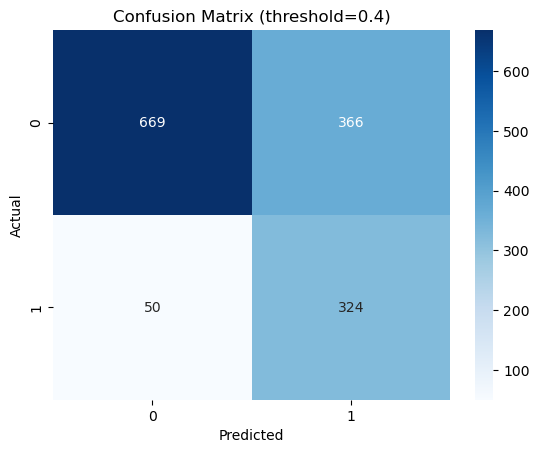

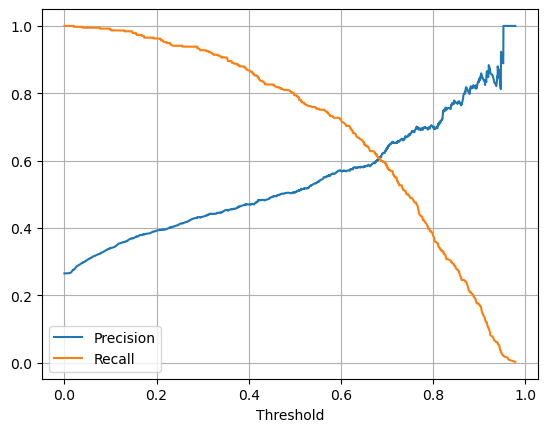

In [7]:

# 5) Train

print("Training model...")
pipeline.fit(X_train, y_train)


# 6) Evaluation

y_proba = pipeline.predict_proba(X_test)[:, 1]

y_pred_default = (y_proba >= 0.5).astype(int)
y_pred_final = (y_proba >= FINAL_THRESHOLD).astype(int)

def print_metrics(y_true, y_pred, title):
    print(f"\n=== {title} ===")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

print_metrics(y_test, y_pred_default, "Default Threshold (0.5)")
print_metrics(y_test, y_pred_final, f"Threshold ({FINAL_THRESHOLD})")

print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (threshold={FINAL_THRESHOLD})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall vs Threshold
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [8]:

# 7) Interpretability (coefficients)

pre = pipeline.named_steps['preprocessor']
clf = pipeline.named_steps['clf']

num_features = pre.transformers_[0][2]
cat_features = pre.transformers_[1][2]
ohe = pre.transformers_[1][1]
ohe_names = ohe.get_feature_names_out(cat_features)

feature_names = list(num_features) + list(ohe_names)
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs
}).sort_values('coef', ascending=False)

coef_df.to_csv(os.path.join(MODEL_DIR, "feature_coefficients.csv"), index=False)

In [9]:

# 8) Save artifacts

joblib.dump(pipeline, os.path.join(MODEL_DIR, "churn_pipeline_final.joblib"))

pd.DataFrame({
    'y_true': y_test.values,
    'y_proba': y_proba,
    'y_pred': y_pred_final
}).to_csv(os.path.join(MODEL_DIR, "test_predictions.csv"), index=False)

pd.Series({
    'precision': precision_score(y_test, y_pred_final),
    'recall': recall_score(y_test, y_pred_final),
    'f1': f1_score(y_test, y_pred_final),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'threshold': FINAL_THRESHOLD
}).to_csv(os.path.join(MODEL_DIR, "metrics_summary.csv"))

print("Project completed successfully.")


Project completed successfully.
